**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

**Требования к решению:**
1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

**Загрузка модулей и данных**

In [47]:
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 14})

In [49]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')

**Просмотр данных**

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [51]:
train.shape, test.shape

((10000, 19), (5000, 18))

In [52]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0000,47.9816,29.4428,6.0000,7,9.0000,1969,0.0890,B,B,33,7976,5,NaN,0,11,B,"184,966.9307"
15053,41,3.0000,65.6836,40.0495,8.0000,7,9.0000,1978,0.0001,B,B,46,10309,1,240.0000,1,16,B,"300,009.4501"
4765,53,2.0000,44.9480,29.1976,0.0000,8,12.0000,1968,0.0496,B,B,34,7759,0,229.0000,1,3,B,"220,925.9085"
5809,58,2.0000,53.3530,52.7315,9.0000,8,17.0000,1977,0.4379,B,B,23,5735,3,"1,084.0000",0,5,B,"175,616.2272"
10783,99,1.0000,39.6492,23.7762,7.0000,11,12.0000,1976,0.0123,B,B,35,5776,1,"2,078.0000",2,4,B,"150,226.5316"


In [53]:
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0000,49.8826,33.4328,6.0000,6,14.0000,1972,0.3102,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0000,69.2632,NaN,1.0000,6,1.0000,1977,0.0758,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0000,13.5978,15.9482,12.0000,2,5.0000,1909,0.0000,B,B,30,7538,87,"4,702.0000",5,5,B
15664,47,2.0000,73.0466,51.9408,9.0000,22,22.0000,2007,0.1019,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0000,47.5271,43.3876,1.0000,17,17.0000,2017,0.0722,B,B,2,629,1,NaN,0,0,A


*Целевая переменная*

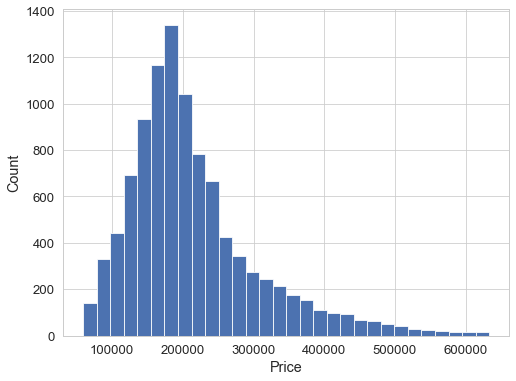

In [54]:
plt.figure(figsize = (8, 6))

train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.show()

*Приведение типов*

In [55]:
train['DistrictId'] = train['DistrictId'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

*Числовые признаки*

In [56]:
feature_num_names = train.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()

In [57]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.0000","10,000.0000","7,887.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","5,202.0000","10,000.0000","10,000.0000","10,000.0000"
mean,1.8905,56.3158,37.1996,6.2733,8.5267,12.6094,"3,990.1663",0.1189,24.6870,"5,352.1574",8.0392,"1,142.9045",1.3195,4.2313,"214,138.8574"
std,0.8395,21.0587,86.2412,28.5609,5.2411,6.7760,"200,500.2614",0.1190,17.5326,"4,006.7998",23.8319,"1,021.5173",1.4936,4.8063,"92,872.2939"
min,0.0000,1.1369,0.3706,0.0000,1.0000,0.0000,"1,910.0000",0.0000,0.0000,168.0000,0.0000,0.0000,0.0000,0.0000,"59,174.7780"
25%,1.0000,41.7749,22.7698,1.0000,4.0000,9.0000,"1,974.0000",0.0176,6.0000,"1,564.0000",0.0000,350.0000,0.0000,1.0000,"153,872.6339"
50%,2.0000,52.5133,32.7813,6.0000,7.0000,13.0000,"1,977.0000",0.0754,25.0000,"5,285.0000",2.0000,900.0000,1.0000,3.0000,"192,269.6449"
75%,2.0000,65.9006,45.1288,9.0000,12.0000,17.0000,"2,001.0000",0.1958,36.0000,"7,227.0000",5.0000,"1,548.0000",2.0000,6.0000,"249,135.4622"
max,19.0000,641.0652,"7,480.5921","2,014.0000",42.0000,117.0000,"20,052,011.0000",0.5219,74.0000,"19,083.0000",141.0000,"4,849.0000",6.0000,23.0000,"633,233.4666"


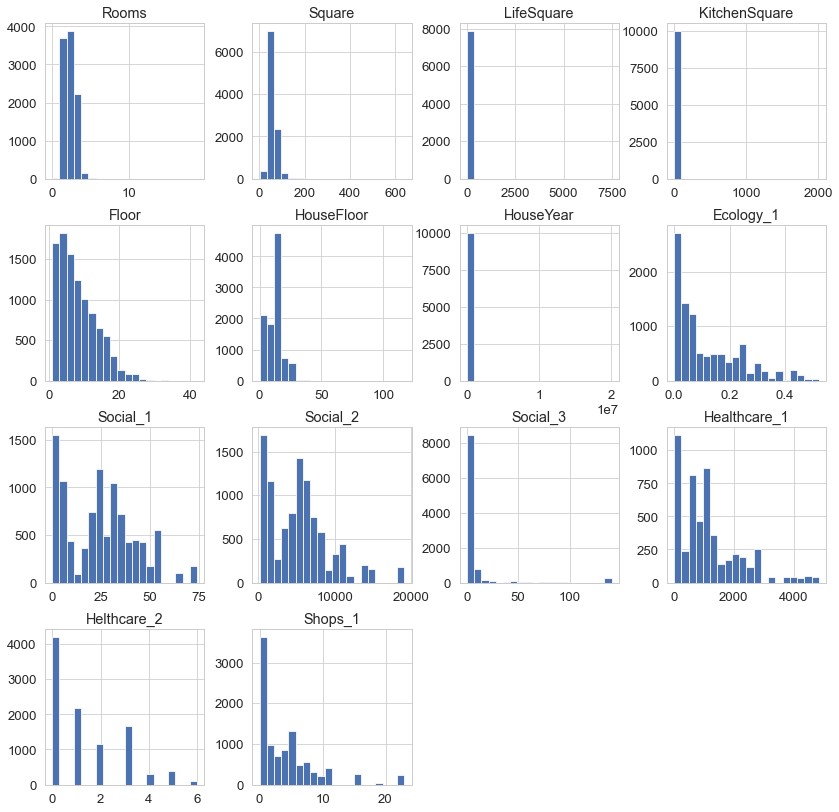

In [58]:
train[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

*Строковые признаки*

In [59]:
train.describe(include='object')

,DistrictId,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000,10000
unique,205,2,2,2
top,27,B,B,B
freq,851,9903,9725,9175


In [60]:
feature_obj_name = train.select_dtypes(include='object').columns.tolist()

In [61]:
for col in feature_obj_name:
    print(train[col].value_counts())

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
207      1
174      1
205      1
117      1
Name: DistrictId, Length: 205, dtype: int64
B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


**Взаимосвязь признаков**

In [62]:
feature_main_names = train.select_dtypes(include=['float64', 'int64'])

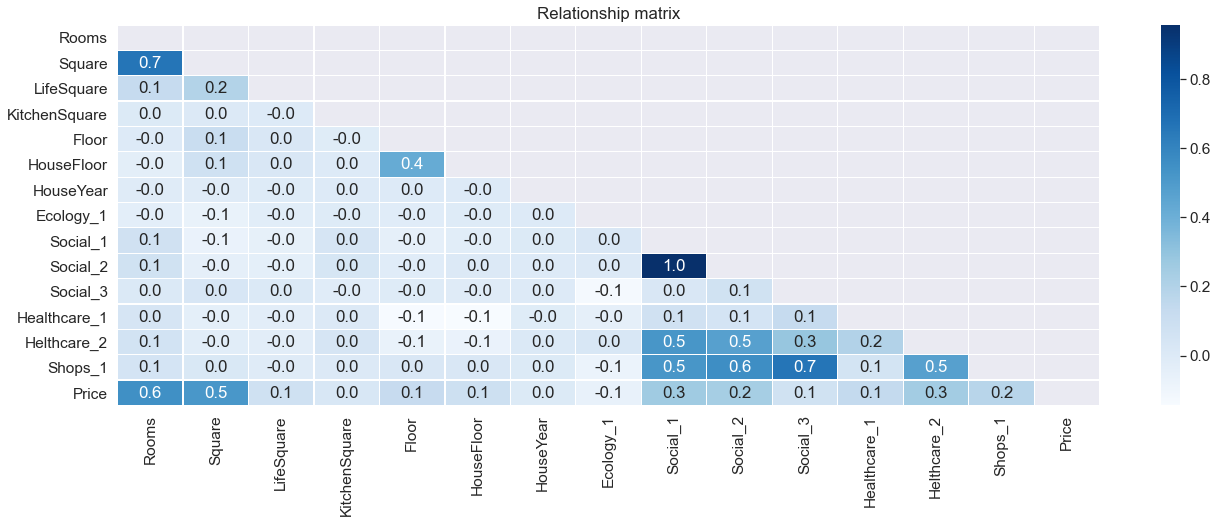

In [63]:
plt.figure(figsize = (22, 7))
mask = np.zeros_like(feature_main_names.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(feature_main_names.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.20, cmap='Blues')
plt.title('Relationship matrix')
plt.show()

**Работа с данными**

*Замена категориальных признаков на числа*

In [64]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})
test[feature_bin_names] = test[feature_bin_names].replace({'A':0, 'B':1})

*Обработка пропусков*

In [65]:
train.isna().sum()[train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [66]:
test.isna().sum()[train.isna().sum() != 0]

LifeSquare      1041
Healthcare_1    2377
dtype: int64

*Устранение выбросов в HouseYear для дальнейшей группировки*

In [67]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2011
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

*LifeSquare*

In [69]:
train.loc[train['LifeSquare'].isna(), 'LifeSquare'] = \
  train['Square'] - train['KitchenSquare']
test.loc[test['LifeSquare'].isna(), 'LifeSquare'] = \
   test['Square'] - test['KitchenSquare']

*Healthcare_1*

In [73]:
train['Healthcare_1'].fillna(train['Healthcare_1'].median(), inplace=True)
test['Healthcare_1'].fillna(train['Healthcare_1'].median(), inplace=True)

**Обработка аномальных значений**

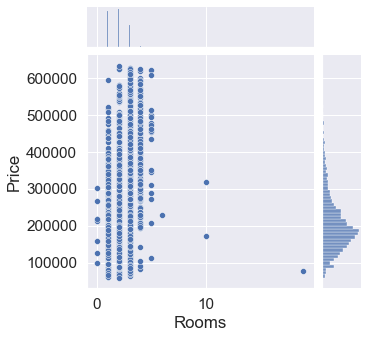

In [76]:
sns.jointplot(train['Rooms'], train['Price'], kind='scatter', height=5);

In [77]:
train.loc[(train['Rooms'] > 5)|(train['Rooms'] == 0), 'Rooms'] = train['Rooms'].mode()[0]
test.loc[(test['Rooms'] > 5)|(test['Rooms'] == 0), 'Rooms'] = train['Rooms'].mode()[0] 

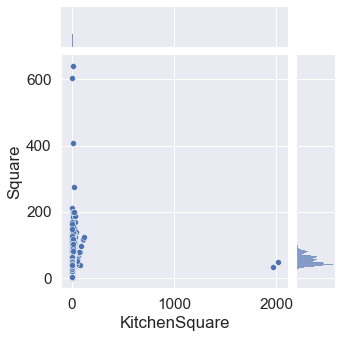

In [78]:
sns.jointplot(train['KitchenSquare'], train['Square'], kind='scatter', height=5);

In [79]:
train.loc[(train['KitchenSquare'] > train['Square']),'KitchenSquare'] = train['KitchenSquare'].median()
test.loc[(test['KitchenSquare'] > test['Square']),'KitchenSquare'] = train['KitchenSquare'].median()

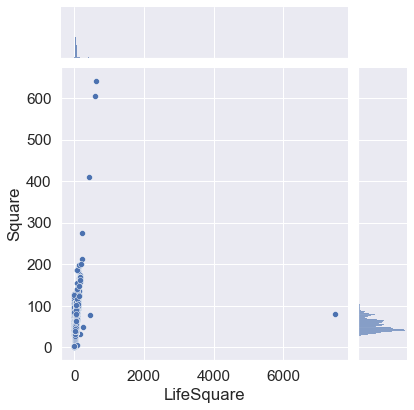

In [80]:
sns.jointplot(train['LifeSquare'], train['Square'], kind='scatter', height=6);

In [81]:
train.loc[(train['LifeSquare'] > train['Square']), 'LifeSquare'] = train['LifeSquare'].median()
test.loc[(test['LifeSquare'] > test['Square']), 'LifeSquare'] = train['LifeSquare'].median()

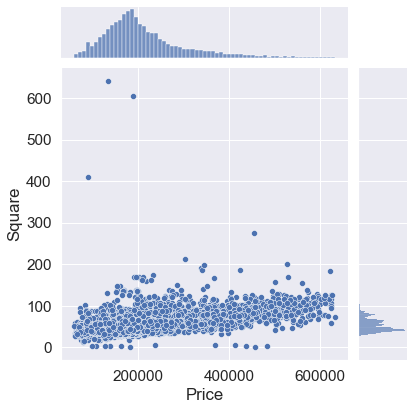

In [82]:
sns.jointplot(train['Price'], train['Square'], kind='scatter', height=6);

In [83]:
train.loc[(train['Square'] > 400), 'Square'] = train['Square'].median()
test.loc[(test['Square'] > 400), 'Square'] = train['Square'].median()

In [84]:
train.loc[(train['Square'] < train['LifeSquare'] + train['KitchenSquare']), 'Square'] = \
    train['LifeSquare'] + train['KitchenSquare']

test.loc[(test['Square'] < test['LifeSquare'] + test['KitchenSquare']), 'Square'] = \
   test['LifeSquare'] + test['KitchenSquare']

**Потсроение новых признаков**

In [85]:
train['RoomSquare'] = train['Square'] / train['Rooms']
test['RoomSquare'] = test['Square'] / test['Rooms']

In [86]:
train['PriceOneRoom'] = train['Price'] / train['Rooms']

price_by_district = train.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

train = train.merge(price_by_district, on=['DistrictId'], how='left').set_index(train.index)
test = test.merge(price_by_district, on=['DistrictId'], how='left').set_index(test.index)

In [87]:
price_by_year = train.groupby(['HouseYear'], as_index=False)\
                        .agg({'Price':'median'})\
                        .rename(columns={'Price':'PriceByYear'})

train = train.merge(price_by_year, on=['HouseYear'], how='left').set_index(train.index)
test = test.merge(price_by_year, on=['HouseYear'], how='left').set_index(test.index)

In [92]:
test.isnull().sum()

DistrictId                0
Rooms                     0
Square                    0
LifeSquare                0
KitchenSquare             0
Floor                     0
HouseFloor                0
HouseYear                 0
Ecology_1                 0
Ecology_2                 0
Ecology_3                 0
Social_1                  0
Social_2                  0
Social_3                  0
Healthcare_1              0
Helthcare_2               0
Shops_1                   0
Shops_2                   0
RoomSquare                0
PriceOneRoomByDistrict    0
PriceByYear               0
dtype: int64

In [91]:
test['PriceOneRoomByDistrict'].fillna(train['PriceOneRoomByDistrict'].median(), inplace=True)
test['PriceByYear'].fillna(train['PriceByYear'].median(), inplace=True)

**Отбор признаков и построение модели**

In [93]:
train.to_csv('train_prepared.csv')
test.to_csv('test_prepared.csv')

In [94]:
feature_names = train.drop(['PriceOneRoom','DistrictId', 'Price'], axis=1).columns.to_list()
target_name = ['Price']

X = train[feature_names]
y = train[target_name]

In [95]:
forest = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.73675


In [96]:
params = {
    'max_depth': [14,15,16],
    'max_features': [3,4,5]
}

In [97]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=5, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_)) 

{'max_depth': 16, 'max_features': 4}
R2 на train: 0.75066


**Прогнозирование на тестовом датасете**

In [98]:
forest_best = RandomForestRegressor(max_depth=16,
                                    max_features=4,
                                    random_state=42)
forest_best.fit(X, y)


RandomForestRegressor(max_depth=16, max_features=4, random_state=42)

In [99]:
y_pred = forest_best.predict(test[feature_names])
y_pred

array([159545.74366157, 235994.78413017, 302525.09618763, ...,
       312906.20721163, 205797.28047834, 172574.77944355])

In [100]:
preds = pd.DataFrame()
preds['Id'] = test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"159,545.7437"
1,15856,"235,994.7841"
2,5480,"302,525.0962"
3,15664,"320,068.0486"
4,14275,"139,101.6413"


In [101]:
preds.to_csv('ChasovskayaAlina_predictions_group1365.csv', index=False)